Want to see what affect taking data 12 times a day instantaneously v.s. taking data 120 times a day then binning it has.

In [12]:
from pickle import load
from functools import partial
import healpy as hp
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from chainconsumer import ChainConsumer

import src.forward_model as FM
import src.beam_functions as BF
import src.sky_models as SM
from anstey.generate import T_CMB
from src.spherical_harmonics import RealSphericalHarmonics, calc_spherical_harmonic_matrix
from src.nregions_models import pix_forward_model_pl, genopt_pix_forward_model_pl
from src.blockmat import BlockMatrix, BlockVector
RS = RealSphericalHarmonics()
from nregions_inference import nuarr
import nregions_inference as NRI
from scipy.optimize import curve_fit
from functools import partial
import alm_polynomial_inference as api
from src.inference import curve_fit_emcee
import src.observing as OBS
import src.map_making as MM
import src.spherical_harmonics as SH
import src.coordinates as CO

from chainconsumer import ChainConsumer
from emcee import EnsembleSampler

alm2temp = 1/np.sqrt(4*np.pi)

def mollviewidx(idx, nside=32):
    """
    Produce mollview plot with idxs set to 1.
    """
    m=np.zeros(hp.nside2npix(nside))
    m[idx]=1
    hp.mollview(m, title='')
    plt.show()

In [25]:
nside   = 32
lmax    = 32
Nlmax   = RS.get_size(lmax)
lats = np.array([-26])#np.array([-26*3, -26*2, -26, 0, 26, 26*2, 26*3])
cm21_params     = OBS.cm21_params
narrow_cosbeam  = lambda x: BF.beam_cos(x, 0.8)

# Generate foreground and 21-cm signal alm
fg_alm   = SM.foreground_gsma_alm_nsidelo(nu=70, lmax=lmax, nside=nside, use_mat_Y=True)
fid_alm  = fg_alm

# Generate observation matrix for the modelling and for the observations.
mat_A_sparse_obs, (mat_G_sparse, mat_P_sparse, _, _) = FM.calc_observation_matrix_multi_zenith_driftscan(nside, lmax, lats=lats, times=np.linspace(0, 24, 240, endpoint=False), Ntau=24, beam_use=narrow_cosbeam, return_mat=True)
mat_A_binned_obs, (mat_G_binned, mat_P_binned, _, _) = FM.calc_observation_matrix_multi_zenith_driftscan(nside, lmax, lats=lats, times=np.linspace(0, 24, 480, endpoint=False), beam_use=narrow_cosbeam, return_mat=True)

# Perform fiducial observations
d_sparse_obs = mat_A_sparse_obs @ fid_alm
d_binned_obs = mat_A_binned_obs @ fid_alm

successfully loaded spherical_harmonic_matrix npix, nalm : 12288 561


In [26]:
d_binned_obs.shape

(480,)

In [27]:
d_sparse_obs.shape

(24,)

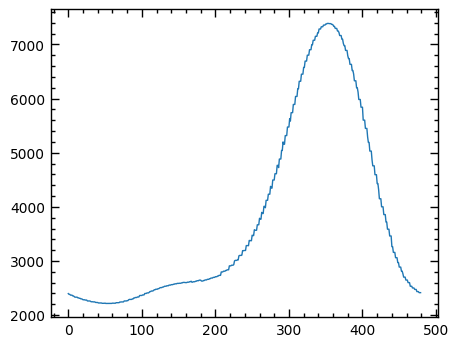

In [28]:
plt.plot(d_binned_obs)

In [29]:
t_sparse, p_sparse = np.nonzero(mat_P_sparse)
t_binned, p_binned = np.nonzero(mat_P_binned)

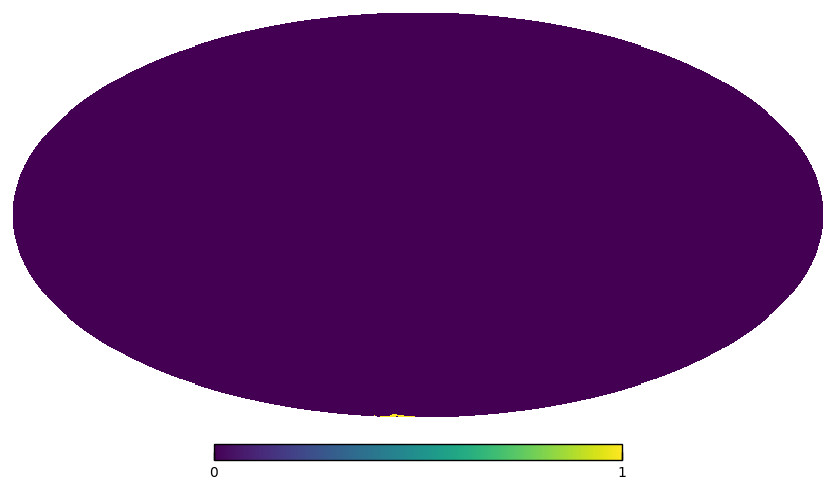

In [31]:
mollviewidx(p_binned[14:18])

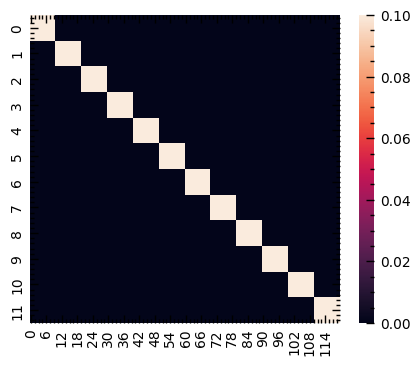

<Axes: >

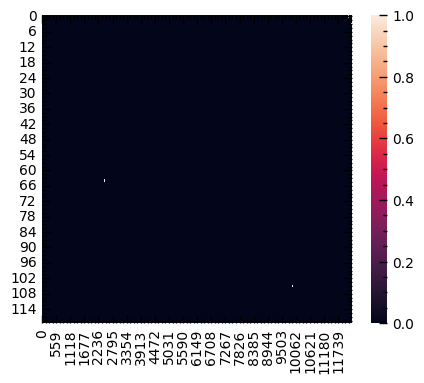

In [27]:
sns.heatmap(mat_G_binned)
plt.show()
sns.heatmap(mat_P_binned)

In [26]:
mat_G_binned.shape

(12, 120)

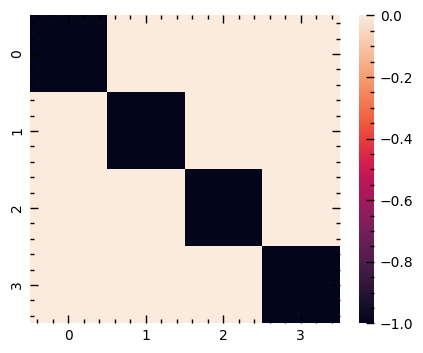

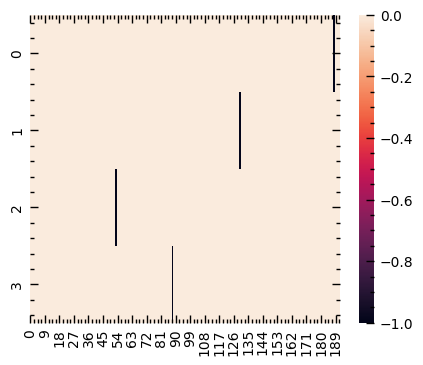

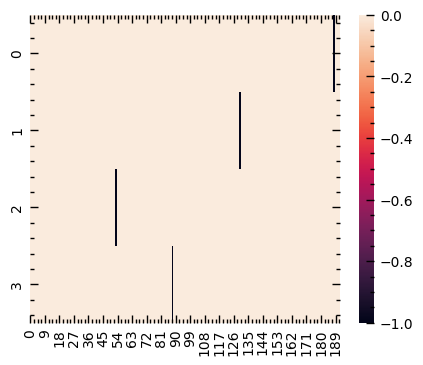

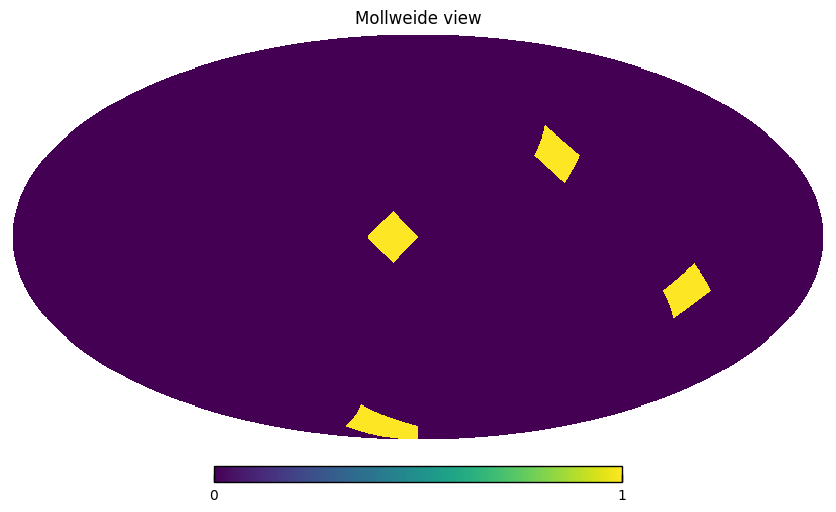

In [55]:
nside  = 4
times  = np.linspace(0, 24, 4, endpoint=False)
mat_G  = FM.calc_averaging_matrix(Ntau=len(times), Nt=len(times))
coords = CO.obs_zenith_drift_scan(lat=-26, lon=0, times=times)
mat_P_sparse, pix  = CO.calc_pointing_matrix(coords, nside=nside, pixels=True)
sns.heatmap(-mat_G)
plt.show()
sns.heatmap(-mat_P_sparse)
plt.show()
sns.heatmap(-mat_G@mat_P_sparse)
plt.show()
m = np.zeros(hp.nside2npix(nside))
m[pix] = 1
hp.mollview(m)
mat_GP_sparse = mat_G@mat_P_sparse

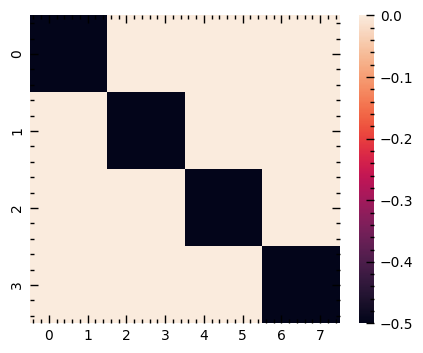

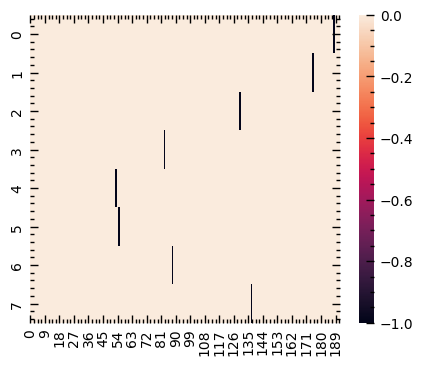

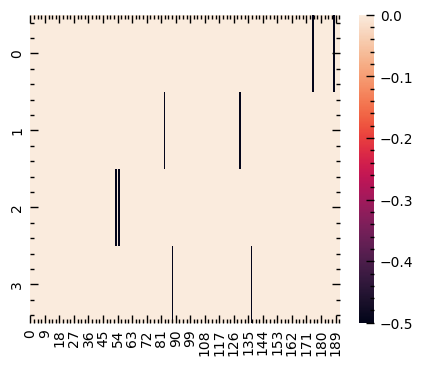

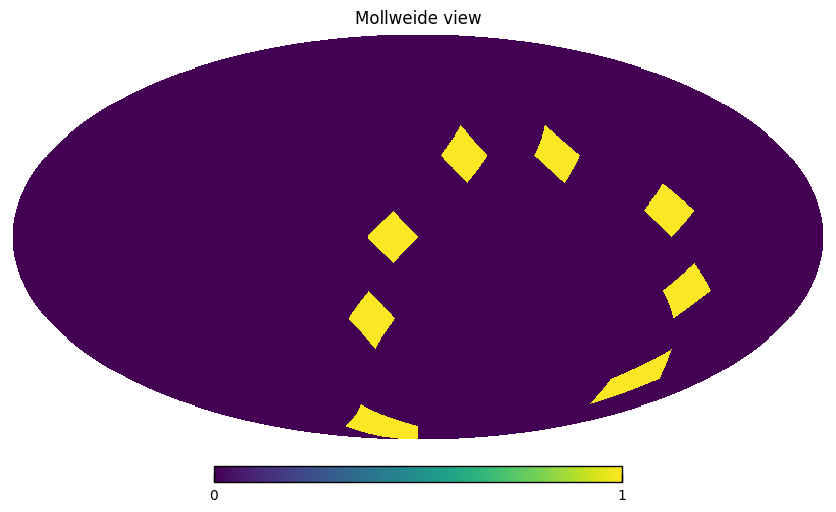

In [56]:
nside  = 4
times  = np.linspace(0, 24, 8, endpoint=False)
mat_G  = FM.calc_averaging_matrix(Ntau=4, Nt=len(times))
coords = CO.obs_zenith_drift_scan(lat=-26, lon=0, times=times)
mat_P_binned, pix  = CO.calc_pointing_matrix(coords, nside=nside, pixels=True)
sns.heatmap(-mat_G)
plt.show()
sns.heatmap(-mat_P_binned)
plt.show()
sns.heatmap(-mat_G@mat_P_binned)
plt.show()
m = np.zeros(hp.nside2npix(nside))
m[pix] = 1
hp.mollview(m)
mat_GP_binned = mat_G@mat_P_binned

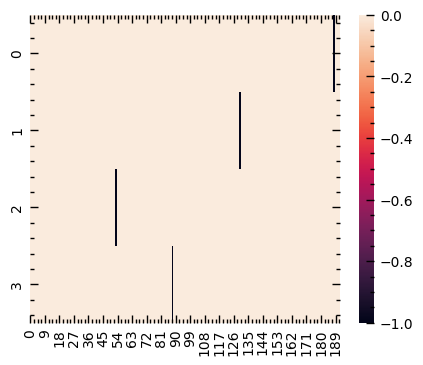

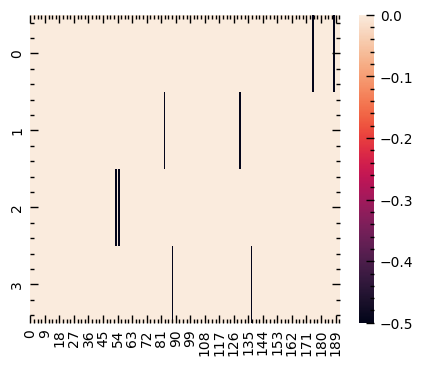

In [54]:
sns.heatmap(-mat_GP_sparse)
plt.show()
sns.heatmap(-mat_GP_binned)
plt.show()

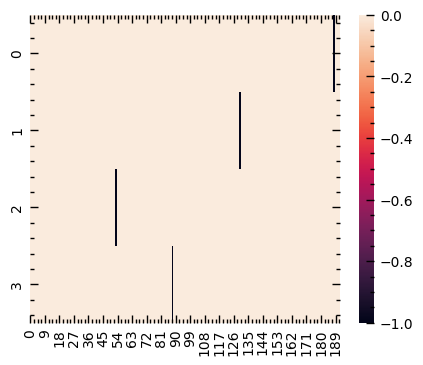

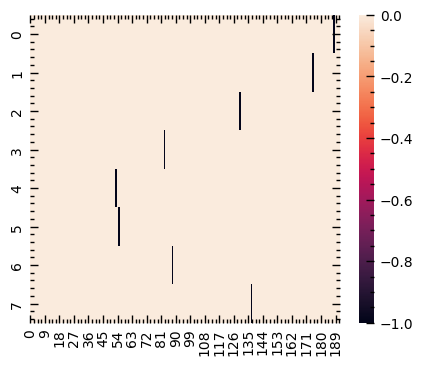

In [57]:
sns.heatmap(-mat_P_sparse)
plt.show()
sns.heatmap(-mat_P_binned)
plt.show()